In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device ,torch.cuda.is_available())

cuda True


In [2]:
import sys,os, pickle

import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import BertForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, random_split
from transformers import AdamW
from tqdm import tqdm  # for our progress bar

from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import numpy as np
from transformers import AutoModelForSequenceClassification

import random


EXPERIMENT_NAME="TYPE_WRITER_40_class"

BATCH_SIZE = 4
MAX_TOKEN_SIZE = 512


/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TYPE_MAPPING ={'int': 0, '*structure': 1, 'array_char': 2, '*char': 3, '*int': 4, 
               'array_int': 5, 'char': 6, 'double': 7, '**char': 8, 'unsigned int': 9,
                 'long int': 10, 'float': 11, 'long unsigned int': 12, 'structure': 13, 
                 'const': 14, '*const': 15, 'long long unsigned int': 16, '*enumeration': 17,
                   'unsigned char': 18, 'long long int': 19, '*unsigned char': 20, 
                   '*float': 21, '**int': 22, '*double': 23, '**structure': 24, '*union': 25, 
                   'short unsigned int': 26, 'enumeration': 27, '*array_int': 28, 
                   'array_double': 29, '*array_float': 30, 'array_structure': 31, 
                   'array_*char': 32, 'short int': 33, 'array_float': 34, '*unsigned int': 35, 
                   'union': 36, '*array_char': 37, '*array_const': 38, 
                   'array_unsigned char': 39, 'signed char': 40, 'array_long int': 41}

    

In [4]:
DATA_PATH = '/home/nahid/dataset/instructions_and_type_data/'
TYPE_COUNT ={}
FINAL_TYPE_COUNT = {}
TYPE_PROBABILITY = {}

for key in TYPE_MAPPING.keys():
    TYPE_COUNT[key] = 0
    FINAL_TYPE_COUNT[key] = 0
    
MAX_TYPE_SAMPLE  =5000
ALL_INPUT_LIST = []
ALL_INPUT_SLICE_INFO  = []
ALL_LABEL_LIST = []
#TODO dont load all at a time in memry
def make_dataset():

    #count how many real samples
    for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
        pkl_path = os.path.join(DATA_PATH,pkl_file_name)

        with open(pkl_path, 'rb') as file:
            model_input_list, model_label_list = pickle.load(file)

            for i in range(len(model_input_list)):

                type_str = model_label_list[i]

                TYPE_COUNT[type_str] +=1
    
    print(TYPE_COUNT)
    #make the probability
    for key in TYPE_COUNT.keys():
        print(MAX_TYPE_SAMPLE , TYPE_COUNT[key] ,key)
        TYPE_PROBABILITY[key] = MAX_TYPE_SAMPLE/TYPE_COUNT[key]
    
    print(TYPE_PROBABILITY)
    #fill dataset with that probability
    for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
        pkl_path = os.path.join(DATA_PATH,pkl_file_name)

        with open(pkl_path, 'rb') as file:
            model_input_list, model_label_list = pickle.load(file)

            for i in range(len(model_input_list)):

                type_str = model_label_list[i]
                type_label = TYPE_MAPPING[type_str]
                backward_slice , target_slice, forward_slice = model_input_list[i]

                if random.random()<=TYPE_PROBABILITY[type_str]:

                    ALL_INPUT_LIST.append(backward_slice + target_slice + forward_slice)
                    ALL_INPUT_SLICE_INFO.append([len(backward_slice) , len(target_slice) , len(forward_slice)])
                    ALL_LABEL_LIST.append(type_label)
                    
                    FINAL_TYPE_COUNT[type_str]+=1
make_dataset()

{'int': 435219, '*structure': 53014, 'array_char': 25295, '*char': 44358, '*int': 29999, 'array_int': 16446, 'char': 18405, 'double': 8624, '**char': 9433, 'unsigned int': 13084, 'long int': 10557, 'float': 8954, 'long unsigned int': 10946, 'structure': 8103, 'const': 7704, '*const': 7246, 'long long unsigned int': 5181, '*enumeration': 279, 'unsigned char': 3569, 'long long int': 6236, '*unsigned char': 3754, '*float': 1082, '**int': 2040, '*double': 1227, '**structure': 3423, '*union': 3123, 'short unsigned int': 1467, 'enumeration': 1487, '*array_int': 1874, 'array_double': 622, '*array_float': 824, 'array_structure': 943, 'array_*char': 563, 'short int': 727, 'array_float': 353, '*unsigned int': 1171, 'union': 748, '*array_char': 676, '*array_const': 1073, 'array_unsigned char': 438, 'signed char': 284, 'array_long int': 279}
5000 435219 int
5000 53014 *structure
5000 25295 array_char
5000 44358 *char
5000 29999 *int
5000 16446 array_int
5000 18405 char
5000 8624 double
5000 9433 *

In [5]:
print(TYPE_COUNT)

print(TYPE_PROBABILITY)
print(FINAL_TYPE_COUNT)

{'int': 435219, '*structure': 53014, 'array_char': 25295, '*char': 44358, '*int': 29999, 'array_int': 16446, 'char': 18405, 'double': 8624, '**char': 9433, 'unsigned int': 13084, 'long int': 10557, 'float': 8954, 'long unsigned int': 10946, 'structure': 8103, 'const': 7704, '*const': 7246, 'long long unsigned int': 5181, '*enumeration': 279, 'unsigned char': 3569, 'long long int': 6236, '*unsigned char': 3754, '*float': 1082, '**int': 2040, '*double': 1227, '**structure': 3423, '*union': 3123, 'short unsigned int': 1467, 'enumeration': 1487, '*array_int': 1874, 'array_double': 622, '*array_float': 824, 'array_structure': 943, 'array_*char': 563, 'short int': 727, 'array_float': 353, '*unsigned int': 1171, 'union': 748, '*array_char': 676, '*array_const': 1073, 'array_unsigned char': 438, 'signed char': 284, 'array_long int': 279}
{'int': 0.011488469023640972, '*structure': 0.09431470932206587, 'array_char': 0.19766752322593398, '*char': 0.11271923891969882, '*int': 0.16667222240741358,

In [6]:
print(len(ALL_INPUT_LIST))

121911


In [7]:
tokenizer  = BertTokenizer.from_pretrained("./multytask-tokenizer")

#https://github.com/huggingface/tokenizers/issues/247

mask_token_id, look_token_id, eoi_token_id = tokenizer.encode('[MASK] [LOOK] [EOI]')[1:-1]

print(mask_token_id, look_token_id, eoi_token_id)

4 6 5


In [8]:

VOCAB_SIZE = tokenizer.vocab_size

print('VOCAB SIZE : ', (tokenizer.vocab_size))

VOCAB SIZE :  17697


In [9]:
# Create model instance
#TODO*** USE PRETRAINED
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(TYPE_MAPPING.items()))
model.to(device)




Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:

# Tokenize input text
# inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
# inputs = tokenizer(ALL_INPUT_LIST, max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')
# print(inputs.keys())

# labels = ALL_LABEL_LIST.to(device)

In [11]:
# print(inputs.keys())
# print(inputs.token_type_ids)
# inputs.token_type_ids[0][0] =1
# print(inputs.token_type_ids)
# #TODO set token type ids

In [12]:
# class BinaryDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings
#     def __getitem__(self, idx):
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#     def __len__(self):
#         return len(self.encodings.input_ids)

In [13]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        tokenized_text = (self.tokenizer(text , max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')).to(device)
        
        # Convert tokens to input IDs
#         input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        
        # Create input tensors
#         input_ids = tokenized_text['input_ids']  #torch.tensor(input_ids)
        label = torch.tensor([label]).to(device)
        
        return tokenized_text, label
        
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.texts)

In [14]:
print(len(ALL_INPUT_LIST ), len(ALL_LABEL_LIST))

121911 121911


In [15]:
dataset = BinaryDataset(ALL_INPUT_LIST, ALL_LABEL_LIST,tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])
train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# global_task2_metrices, global_task1_metrices ,v_global_task1_metrices, v_global_task2_metrices

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(task1_metrices,   v_task1_metrices, label = "TypeGraph" ):
    
    plt.ioff()

    font_size = 10
    x_labels = [ i for i in range(len(task1_metrices)) ]
    
    task1_f1 = [ i['f1'] for i in task1_metrices ]

    
    v_task1_f1 = [ i['f1'] for i in v_task1_metrices ]

    

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, task1_f1 , 'r') 

    
    plt.plot(x_labels, v_task1_f1 , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val' ], loc='upper left')
    
    plt.savefig('./output/'+label+'_f1.pdf')
    plt.close()
    plt.show()
    
    ################################
    ################# LOSS #########
    ################################
    
    task1_loss = [ i['loss'] for i in task1_metrices ]

    
    v_task1_loss = [ i['loss'] for i in v_task1_metrices ]
    

    plt.ylabel(' LOSS ',fontsize=font_size)
    plt.plot(x_labels, task1_loss , 'r') 
    
    plt.plot(x_labels, v_task1_loss , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val'], loc='upper left')
    
    plt.savefig('./output/'+label+'_loss.pdf')
    plt.close()
    plt.show()
    
    

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, label='confusion_matrix'):

    class_labels = list(TYPE_MAPPING.keys())  
    class_labels = [c for c in class_labels]

    cm = confusion_matrix(true_labels, predicted_labels ) 
    
    fig, ax = plt.subplots(figsize=(12, 14))
    
    res = sns.heatmap(cm,
            annot=True , cmap="Blues" , fmt='g' , xticklabels=class_labels,linewidths = .01,
                      yticklabels=class_labels,linecolor="Gray")
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.savefig('./output/'+label+'_conf.pdf',dpi=200)
    plt.show()
    plt.close()
    

In [18]:


# initialize optimizer
optim = AdamW( model.parameters() , lr=5e-6)
criterion = nn.CrossEntropyLoss()

In [19]:
def training_loop(model ,data_loop, is_training = False):
    
    prediction_s, ground_truth_s = [], []
    losses = []

    for N,batch in enumerate(data_loop):
        
        
        # Forward pass
        if is_training == True:
            optim.zero_grad()
        
        batch_input, batch_labels = batch
        if len(batch_labels)<BATCH_SIZE:
            continue
        batch_input_ids= batch_input['input_ids']
        batch_attention_mask=batch_input['attention_mask']
        batch_token_type_ids =batch_input['token_type_ids']

        outputs = model(input_ids=batch_input_ids.squeeze(),
                        attention_mask=batch_attention_mask.squeeze(),
                        token_type_ids=batch_token_type_ids.squeeze(),
                        labels=batch_labels )
        
#

        loss = outputs.loss
        losses.append(loss.item())
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        


        prediction_s.extend(predictions.detach().cpu().numpy().flatten())
        ground_truth_s.extend(batch_labels.detach().cpu().numpy().flatten())


        if is_training == True:
            loss.backward()
            optim.step()


        # print relevant info to progress bar
        data_loop.set_description(f'Epoch {ecpoch}')
        data_loop.set_postfix(loss=loss.item())

    ###### Training Scores
    accuracy = accuracy_score(ground_truth_s, prediction_s)    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_s,prediction_s,average='weighted')
    metrices = {'accuracy':accuracy ,
                      'precision':precision, 
                      'recall':recall, 
                      'f1':f1,
                      'loss': (sum(losses) / len(losses))}
    


    return metrices , prediction_s, ground_truth_s
    

Epoch 0: 100%|██████████████| 24382/24382 [4:13:44<00:00,  1.60it/s, loss=0.776]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training metrices:  {'accuracy': 0.47138257731113115, 'precision': 0.46788958454300517, 'recall': 0.47138257731113115, 'f1': 0.45221752774003254, 'loss': 1.9782297843050407}


Epoch 0: 100%|███████████████████| 6096/6096 [34:20<00:00,  2.96it/s, loss=0.93]
/home/nahid/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


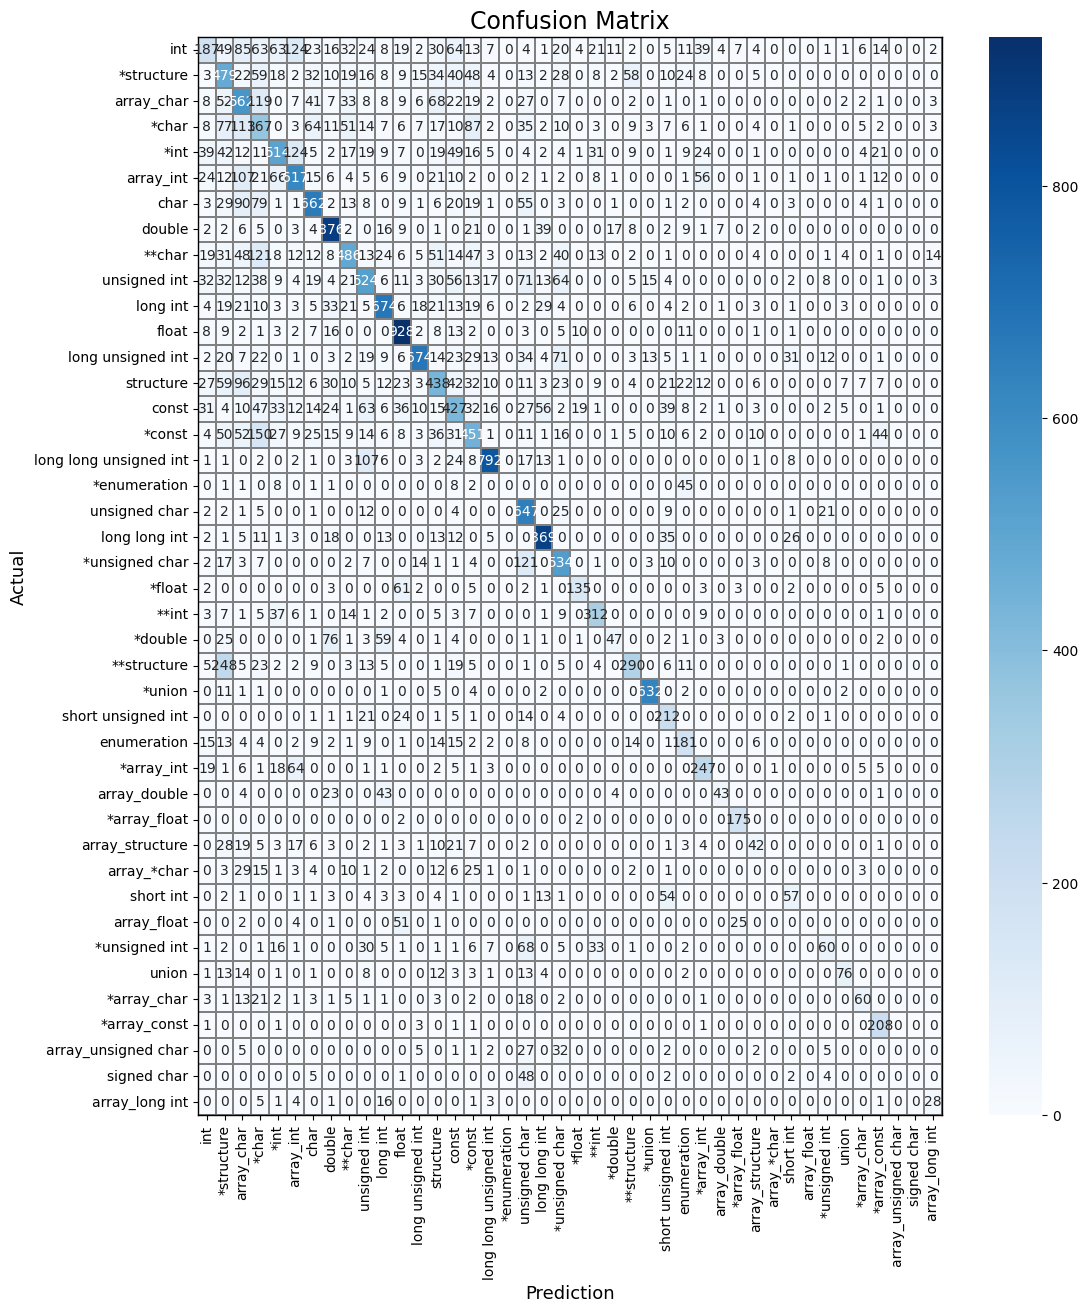

v_metrices:  {'accuracy': 0.5952830188679246, 'precision': 0.5956139966815097, 'recall': 0.5952830188679246, 'f1': 0.5855842313013959, 'loss': 1.4480767065287858}


Epoch 1: 100%|██████████████| 24382/24382 [4:09:33<00:00,  1.63it/s, loss=0.288]


Training metrices:  {'accuracy': 0.6247026494955294, 'precision': 0.6211836671735765, 'recall': 0.6247026494955294, 'f1': 0.6160648885512894, 'loss': 1.3157518767748622}


Epoch 1: 100%|███████████████████| 6096/6096 [34:15<00:00,  2.97it/s, loss=1.73]


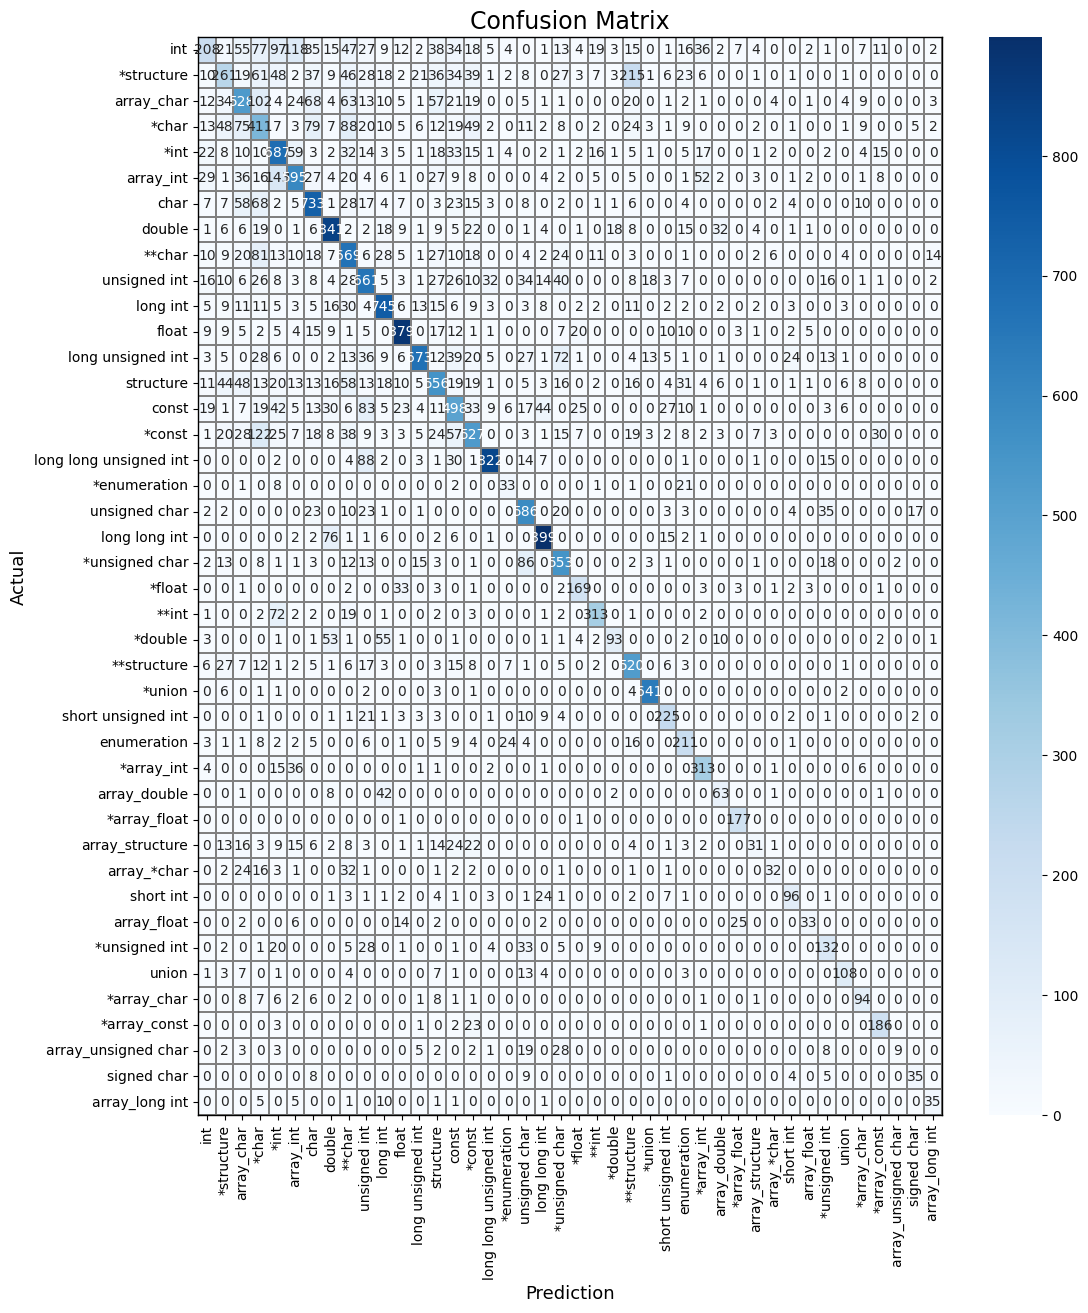

v_metrices:  {'accuracy': 0.651394585726005, 'precision': 0.6536142153058984, 'recall': 0.651394585726005, 'f1': 0.6432217068765341, 'loss': 1.1870517819783695}


Epoch 2: 100%|██████████████| 24382/24382 [4:09:40<00:00,  1.63it/s, loss=0.575]


Training metrices:  {'accuracy': 0.6693462390287918, 'precision': 0.6647920558882142, 'recall': 0.6693462390287918, 'f1': 0.6616812231048252, 'loss': 1.105341064360733}


Epoch 2: 100%|███████████████████| 6096/6096 [34:21<00:00,  2.96it/s, loss=1.91]


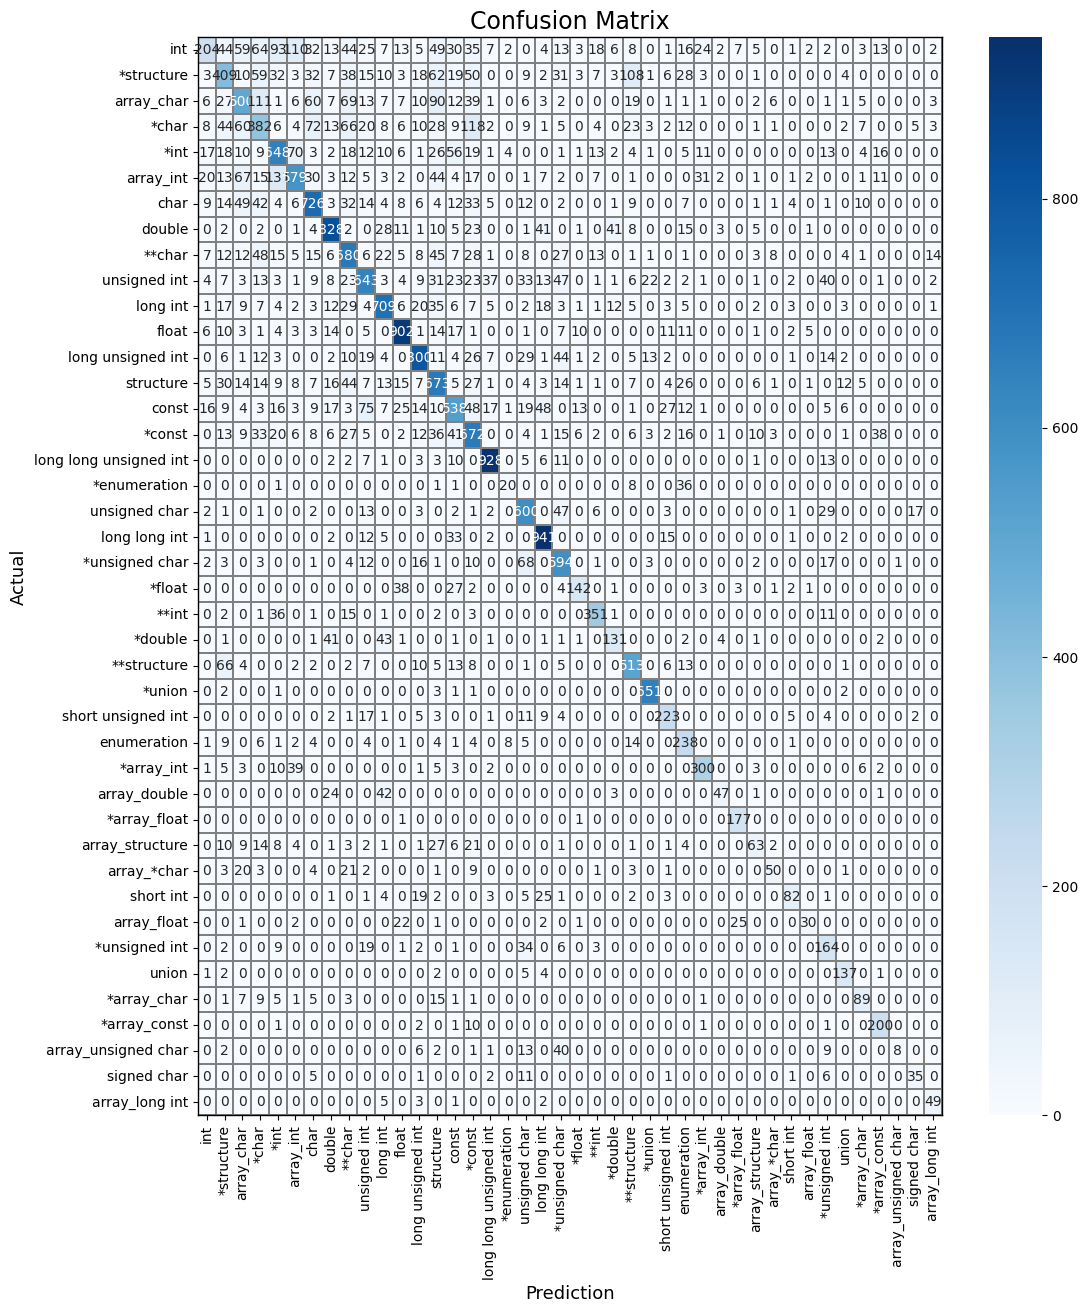

v_metrices:  {'accuracy': 0.6831829368334701, 'precision': 0.6837330994415536, 'recall': 0.6831829368334701, 'f1': 0.6738726068823783, 'loss': 1.0541361717829654}


Epoch 3: 100%|██████████████| 24382/24382 [4:12:57<00:00,  1.61it/s, loss=0.597]


Training metrices:  {'accuracy': 0.6956053646132393, 'precision': 0.6912674138768636, 'recall': 0.6956053646132393, 'f1': 0.68819367825165, 'loss': 0.98312841373505}


Epoch 3: 100%|██████████████████| 6096/6096 [34:34<00:00,  2.94it/s, loss=0.727]


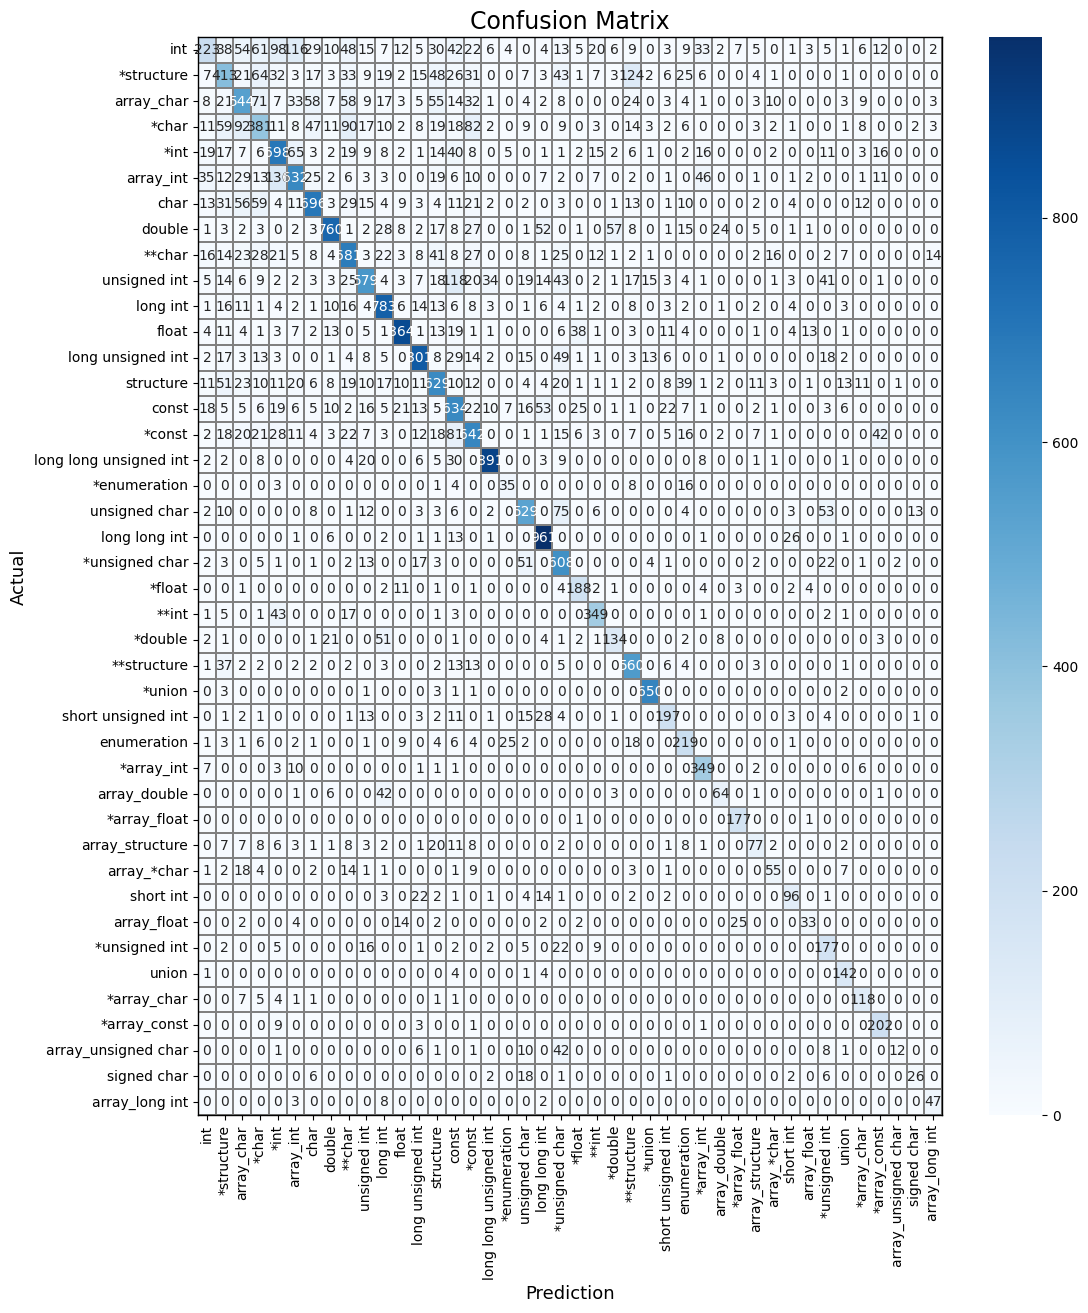

v_metrices:  {'accuracy': 0.6913863822805578, 'precision': 0.6910040760365005, 'recall': 0.6913863822805578, 'f1': 0.6838421020816184, 'loss': 1.0061563564857148}


Epoch 4: 100%|███████████████| 24382/24382 [4:12:50<00:00,  1.61it/s, loss=1.83]


Training metrices:  {'accuracy': 0.7143384463948814, 'precision': 0.7105864315501869, 'recall': 0.7143384463948814, 'f1': 0.7072995292631256, 'loss': 0.9000741770406894}


Epoch 4: 100%|██████████████████| 6096/6096 [34:23<00:00,  2.95it/s, loss=0.802]


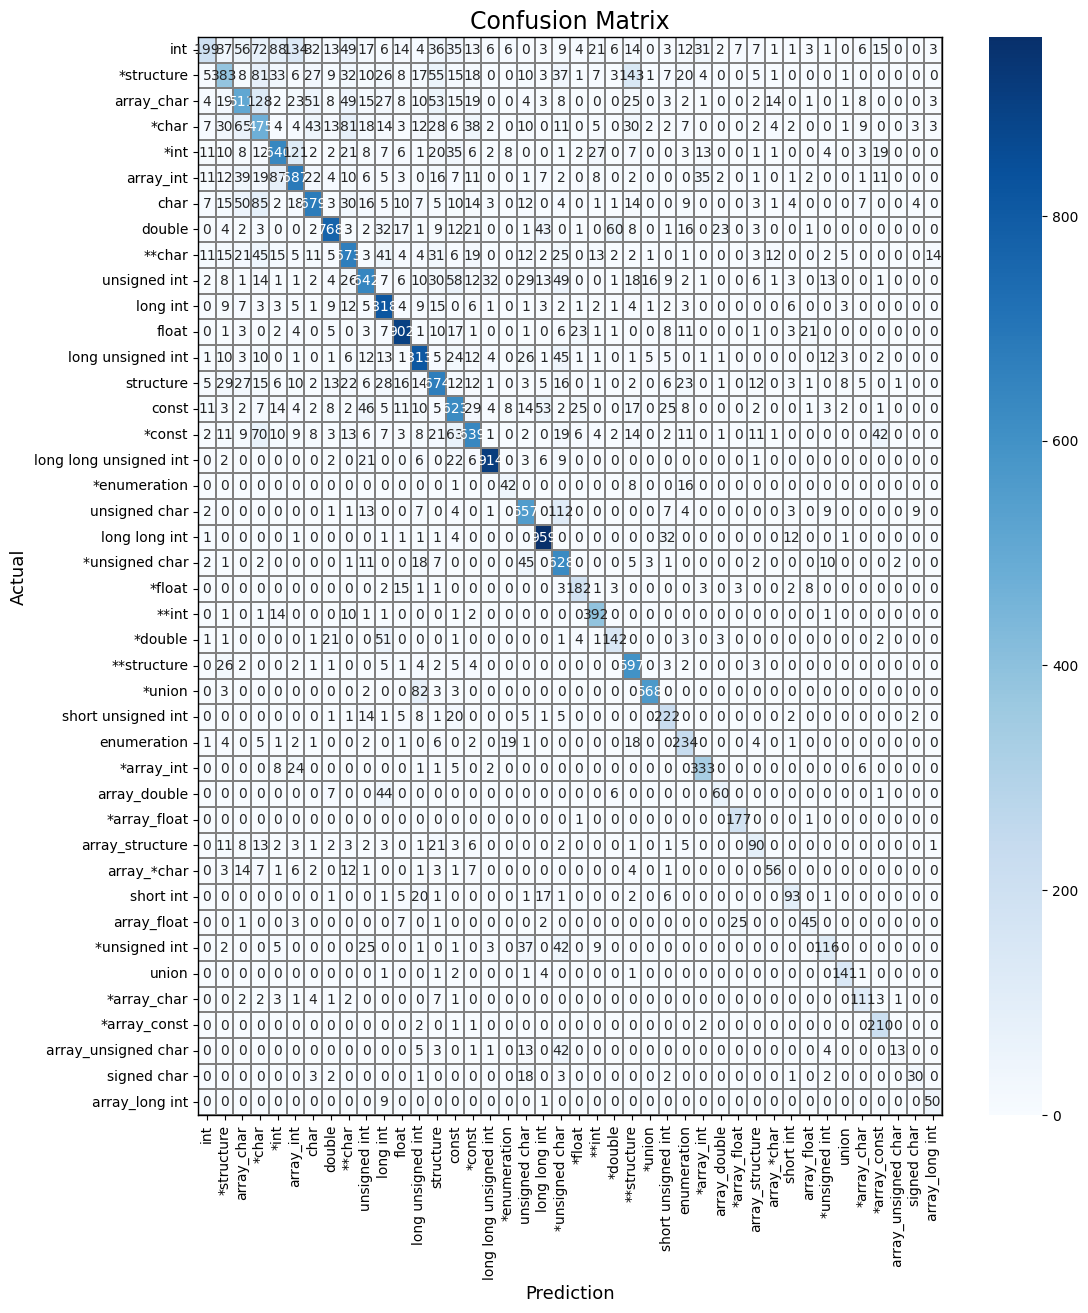

v_metrices:  {'accuracy': 0.7009023789991796, 'precision': 0.7041723234780299, 'recall': 0.7009023789991796, 'f1': 0.6918226598896728, 'loss': 0.9609471899931723}


Epoch 5:  44%|█████▎      | 10698/24382 [1:52:55<2:27:54,  1.54it/s, loss=0.314]

In [ ]:
EPOCHS = 100


global_metrices = []
v_global_metrices = []


for ecpoch in range(EPOCHS):
    
    train_loop = tqdm(train_loader, leave=True)
    model.train()
    metrices,prediction_s, ground_truth_s  = training_loop(model ,train_loop, is_training = True)
    print('Training metrices: ',metrices)
    global_metrices.append(metrices)
    
    with torch.no_grad():
        model.eval()
        validation_loop = tqdm(validation_loader, leave=True)
        v_metrices, v_prediction_s, v_ground_truth_s  = training_loop(model ,validation_loop, is_training = False)
        plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)
        print('v_metrices: ',v_metrices)
        v_global_metrices.append(v_metrices)
    plot_graph(global_metrices,v_global_metrices , label = EXPERIMENT_NAME)
#     break
    model.save_pretrained('/home/nahid/dataset/model_trained/'+EXPERIMENT_NAME)


In [ ]:
model.save_pretrained('/home/nahid/dataset/model_trained/'+EXPERIMENT_NAME)